
# Coursera Capstone Project - The Battle of Neighborhoods
## 1. Introduction
This notebook is the capstone project of IBM's Applied Data Science Coursera in the Coursera platform. During the last module, we analyzed data from New York City and Toronto, and used the Foursquare API to get information about recommended venues in different areas of both cities.

This project will make something similar, but in Madrid, Spain. The main objective of the project is to get an idea of the characteristics of the different neighborhoods of the city, and to figure out the best neighborhood to open a specific type of restaurant. Madrid is divided into 21 districts and 131 neighborhoods. In order to do this, we will leverage some open data provided by the Municipality of Madrid, as well as data from the FourSquare API. The next section will present the different data that will be used throughout the project.

Before we start discussing the data, let's import the packages we need

In [1]:
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

## 2. The data
The municipality of Madrid has made available to the public more than 400 datasets about different aspects of the city. All data can be found in [this website](https://datos.madrid.es/portal/site/egob/) (in Spanish). Within this project, we will use the following datasets from the website:
* [Neighborhoods, with area and perimeter](https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv) (CSV, 10 Kbytes) - Full relation of the 131 neighborhoods in Madrid
* [Districts, with area and number of neighborhoods](https://datos.madrid.es/egob/catalogo/200078-4-distritos-barrios.csv) (CSV, 1 Kbyte) - Name, area and number of neighborhoods of the 21 districts in Madrid.
* [Catalog of venues and their activities (December 2020)](https://datos.madrid.es/egob/catalogo/209548-252-censo-locales-historico.csv) (CSV, 60491 Kbytes) - Comprehensive catalog of all venues in Madrid, along with their status (e.g. whether it is open of closed, etc.). We will also get information about the venues in each neighborhood
* [Catalog of venues and their activities (December 2019)](https://datos.madrid.es/egob/catalogo/209548-204-censo-locales-historico.csv) - Same as before, but as the COVID-19 pandemics has had a great impact in the hostelry sector, it might be interesting to check out which neighborhoods have been more affected by the pandemics. 
* [Municipal population census (December 2020)](https://datos.madrid.es/egob/catalogo/209163-172-padron-municipal-historico.csv) - Information about the population of each neighborhood, including gender, nationality and age.

We will use maps to represent some of the information. For that, we will need geographical data about Madrid. We will use the following resources:

* [Madrid Neighborhoods (geojson)](https://davideme.carto.com/tables/barrios/public/map)
* [Madrid districts (geojson)](https://team.carto.com/u/jsanz/tables/distritos/public)

Before getting into the capture and analysis of the data, let's import some common use libraries:

### 2.1. Madrid Neighborhoods
The last cell), the City of Madrid has 131 neighborhoods. The Municipality of Madrid provides information about every neighborhood in CSV format in this link: https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv. Let's start by getting the data 

In [2]:
!wget -O 'data/neighborhoods.csv' https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv

--2021-02-12 16:25:58--  https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv
Resolviendo datos.madrid.es (datos.madrid.es)... 2.17.39.80, 2.17.39.139
Conectando con datos.madrid.es (datos.madrid.es)[2.17.39.80]:443... conectado.
Petición HTTP enviada, esperando respuesta... 302 Moved Temporarily
Localización: https://datos.madrid.es:443/datosabiertos/BDC/CALLEJERO_VIGENTE/BARRIOS/2018/09/CALLEJERO_VIGENTE_BARRIOS_201809.csv [siguiendo]
--2021-02-12 16:25:59--  https://datos.madrid.es/datosabiertos/BDC/CALLEJERO_VIGENTE/BARRIOS/2018/09/CALLEJERO_VIGENTE_BARRIOS_201809.csv
Reutilizando la conexión con datos.madrid.es:443.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 10359 (10K) [text/csv]
Grabando a: «data/neighborhoods.csv»

data/neighborhoods. 100%[===================>]  10,12K  --.-KB/s    en 0s      

2021-02-12 16:26:00 (62,9 MB/s) - «data/neighborhoods.csv» guardado [10359/10359]



In [3]:
# Then we read the csv file we have downloaded into a pandas dataframe
nb = pd.read_csv('data/neighborhoods.csv', sep=';', encoding='ISO-8859-1')

In [4]:
# Let's check some info about the dataframe
nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Codigo de barrio                     131 non-null    int64 
 1   Codigo de distrito al que pertenece  131 non-null    int64 
 2   Nombre de barrio                     131 non-null    object
 3   Nombre acentuado del barrio          131 non-null    object
 4   Superficie (m2)                      131 non-null    int64 
 5   Perimetro (m)                        131 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 6.3+ KB


In [5]:
# As expected, we have 131 rows. Let's check the first 5 rows to get an idea about the data
nb.head()

Codigo de barrio  Codigo de distrito al que pertenece  \
0                 1                                    1   
1                 1                                    2   
2                 1                                    3   
3                 1                                    4   
4                 1                                    5   

       Nombre de barrio Nombre acentuado del barrio  Superficie (m2)  \
0  PALACIO                     PALACIO                       1471085   
1  IMPERIAL                    IMPERIAL                       967500   
2  PACIFICO                    PACÍFICO                       750065   
3  RECOLETOS                   RECOLETOS                      870857   
4  EL VISO                     EL VISO                       1708046   

   Perimetro (m)  
0           5754  
1           4557  
2           4005  
3           3927  
4           5269

The neighborhoods table has the following columns:
* ```Codigo de barrio``` (*neighborhood code*) - unique code that identifies the neighborhood within a district
* ```Codigo de distrito al que pertenece``` (*code of the district that the neighborhood belongs to*) - unique code that identifies the district the neighborhood belongs to. This code is the same as the district code from the district table.
* ```Nombre de barrio``` - name of the neighborhood (in all caps)
* ```Nombre acentuado del barrio``` - name of the neighborhood, with accents (in all caps)
* ```Superficie (m2)``` - Area, in square meters
* ```Perimetro (m)``` - Perimeter, in meters

This dataframe does not include relevant geographic information. 

Other data sources that will be presented later include a unique code that identifies the neighborhood: this code is calculated by concatenating the district code (2nd column) and the neighborhood code (1st columnn) (in two digits format), separated with a "0" or with a "-". Let's add a couple of columns with this code

In [6]:
# We create the unique code that will identify each neighborhood and store it in a column
nb['code'] = nb['Codigo de distrito al que pertenece'].map(str) + '0' + nb['Codigo de barrio'].map(str)

In [7]:
# The geojson file that we will use for Chorophleth maps identifies the neighborhoods by
# concatenating the district code + a hyphen (in lieu of the zero) + the neighborhood code.
# This function replaces the zeros in the code with hyphens in case we need to repeat this action 
def replaceZeroWithHyphen(codes):
    return [code[:-2] + "-" + code[-1] for code in codes.astype(str)]

In [8]:
# Let's check if the function works
nb['codbarrio'] = replaceZeroWithHyphen(nb['code'])
nb.sample(5)

Codigo de barrio  Codigo de distrito al que pertenece  \
108                 6                                    7   
32                  2                                   12   
59                  3                                   18   
118                 6                                   20   
33                  2                                   13   

         Nombre de barrio Nombre acentuado del barrio  Superficie (m2)  \
108  VALLEHERMOSO                VALLEHERMOSO                  1068709   
32   ORCASUR                     ORCASUR                       1384234   
59   ENSANCHE DE VALLECAS        ENSANCHE DE VALLECAS                0   
118  REJAS                       REJAS                         5007305   
33   SAN DIEGO                   SAN DIEGO                     1069944   

     Perimetro (m)  code codbarrio  
108           4221   706       7-6  
32            5962  1202      12-2  
59               0  1803      18-3  
118          13360  2006      20-6  
33            4726  1302      13-2

Before getting geographical information about the neighborhoods, let's first clean up the dataframe

In [9]:
# Remove the columns we won't use
nb_final = nb.drop(columns=["Nombre acentuado del barrio"])
nb_final.rename(columns={'Codigo de barrio': 'neighborhood code',
                         'Codigo de distrito al que pertenece': 'district code',
                         'Nombre de barrio': 'name',
                         'Superficie (m2)': 'area (m2)',
                         'Perimetro (m)': 'perimeter (m)'},
                inplace=True)

nb_final.head(1)

neighborhood code  district code                  name  area (m2)  \
0                  1              1  PALACIO                 1471085   

   perimeter (m) code codbarrio  
0           5754  101       1-1

In order to calculate the coordinates for each district, we have used the Nominatim library (see cell below). However, in order to minimize the number of requests to third-party services, we have stored this information in a local file. The next cell shows the code used for getting the geographical information in the first place

In [10]:
# First, we created a dataframe to host the data, with 3 columns: the neighborhood code, the latitude
# and the longitude of each neighborhood

# latlngdf_columns = ['codbar', 'latitude', 'longitude']
# latlngdf = pd.DataFrame(columns=latlngdf_columns)

# locator = Nominatim(user_agent='capstone_geolocator')

# for code, name in list(zip(nb['code'], nb['Nombre de barrio'])):
#    location = locator.geocode('{}, Madrid, Spain'.format(name))
#    try:
#        row = [code, location.latitude, location.longitude]
#    except:
#        row = [code, np.nan, np.nan]
#    latlngdf = latlngdf.append(pd.DataFrame([row], columns=latlngdf_columns), ignore_index=True)

# latlngdf.to_csv('data/madrid_neighborhoods_coordinates.csv')

In [11]:
# We will center all city maps around this coordinate
mad_ll=[40.46206,-3.6766]

In [12]:
# We read the csv file containing the coordinates for each neighborhood, check the first rows
nb_coor = pd.read_csv('data/madrid_neighborhoods_coordinates.csv', index_col=0)
nb_coor.head(3)

code   latitude  longitude
0   101  40.416841  -3.711605
1   201  40.406598  -3.719600
2   301  40.404606  -3.678362

In [14]:
# As we have the code, we merge the dataframe with information about the neighborhood and
# the dataframe with the coordinates for each neighborhood. Check the resulting dataframe
# First, we need to cast the 'code' column in nb_coor to string
nb_coor['code'] = nb_coor['code'].astype('str')
nb_final = nb_final.merge(nb_coor, on="code")
nb_final.head()

neighborhood code  district code                  name  area (m2)  \
0                  1              1  PALACIO                 1471085   
1                  1              2  IMPERIAL                 967500   
2                  1              3  PACIFICO                 750065   
3                  1              4  RECOLETOS                870857   
4                  1              5  EL VISO                 1708046   

   perimeter (m) code codbarrio   latitude  longitude  
0           5754  101       1-1  40.416841  -3.711605  
1           4557  201       2-1  40.406598  -3.719600  
2           4005  301       3-1  40.404606  -3.678362  
3           3927  401       4-1  40.424700  -3.685462  
4           5269  501       5-1  40.449060  -3.686285

In order to get an idea of the distribution of the neighborhoods - and also to check the accuracy of the coordinates we got from the geocoding service, let's print a map that includes a marker in each neighborhood coordinate, as well as the neighborhood limits obtained from a .geojson file available in CartoDB ([link here](https://davideme.carto.com/tables/barrios/public/map))

In [18]:
neighborhoods_geojson = f"data/barrios.geojson"

mn = folium.Map(location=mad_ll, zoom_start=11)

folium.GeoJson(neighborhoods_geojson, name="geojson").add_to(mn)

for name, code, lat, lng in list(zip(nb_final['name'], nb_final['code'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=50,
        location=[lat,lng],
        popup="{} - {}".format(code, name),
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(mn)

mn

In [ ]:
nb_final[['code', 'latitude', 'longitude']].to_csv('data/madrid_neighborhoods_coordinates.csv')

### 2.2. Venues and their activities (from the Open Data Portal)
In the following sections we will use the FourSquare API to get information about the recommended venues in the neighborhoods of Madrid. However, the Municipality of Madrid provides a catalog of all venues and their activities in the city of Madrid, updated monthly. Let's take a look at the information available here.

In [19]:
# We have already downloaded the CSV file, so let's read it using read_csv
venues = pd.read_csv("data/Locales202012.csv",
                     sep=";",
                     header=0,
                     index_col=0,
                     usecols=list(range(40)),
                     encoding="ISO-8859-1")

In [20]:
# Let's take a look at the first 5 rows to get an idea of the information available
venues.head()

id_distrito_local   desc_distrito_local  id_barrio_local  \
id_local                                                             
10000004                  1  CENTRO                            105   
10000105                  1  CENTRO                            104   
10000162                  1  CENTRO                            104   
10000224                  1  CENTRO                            102   
10000284                  1  CENTRO                            103   

             desc_barrio_local  cod_barrio_local  id_seccion_censal_local  \
id_local                                                                    
10000004  UNIVERSIDAD                        NaN                      NaN   
10000105  JUSTICIA                           NaN                      NaN   
10000162  JUSTICIA                           NaN                      NaN   
10000224  EMBAJADORES                        NaN                      NaN   
10000284  CORTES                             NaN                      NaN   

          desc_seccion_censal_local coordenada_x_local coordenada_y_local  \
id_local                                                                    
10000004                        106           439945,6         4475591,53   
10000105                         84          440958,59         4475092,52   
10000162                         88                  0                  0   
10000224                         35                  0                  0   
10000284                         65          440755,59         4473926,52   

          id_tipo_acceso_local  ... cal_acceso  coordenada_x_agrupacion  \
id_local                        ...                                       
10000004                   NaN  ...                                 NaN   
10000105                   NaN  ...                                 NaN   
10000162                   NaN  ...                           440692,59   
10000224                   NaN  ...                           440295,59   
10000284                   NaN  ...                                 NaN   

         coordenada_y_agrup  id_agrupacion                  nombre_agrupacion  \
id_local                                                                        
10000004                NaN            NaN                                NaN   
10000105                NaN            NaN                                NaN   
10000162         4475369,53     99000056.0      MERCADO MUNICIPAL DE  BARCELO   
10000224         4473246,53     99000057.0  MERCADO MUNICIPAL DE SAN FERNANDO   
10000284                NaN            NaN                                NaN   

         id_tipo_agrup    desc_tipo_agrup  id_planta_agrupado  \
id_local                                                        
10000004           NaN                NaN                  PB   
10000105           NaN                NaN                  PB   
10000162          12.0  Mercado Municipal                   0   
10000224          12.0  Mercado Municipal                  PB   
10000284           NaN                NaN                  PB   

         id_local_agrupado                                             rotulo  
id_local                                                                       
10000004               NaN  BAR LA PARADA                                 ...  
10000105               NaN                                         LA MORDIDA  
10000162               101                     POLLERIAS RODRIGUEZ & MARTINEZ  
10000224                70                                         SIN ROTULO  
10000284               NaN                               RESTAURANTE DAR MONA  

[5 rows x 39 columns]

In [21]:
# let's explore the structure a little deeper using .info()
venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146514 entries, 10000004 to 290001652
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id_distrito_local          146514 non-null  int64  
 1   desc_distrito_local        146514 non-null  object 
 2   id_barrio_local            146514 non-null  int64  
 3   desc_barrio_local          146514 non-null  object 
 4   cod_barrio_local           0 non-null       float64
 5   id_seccion_censal_local    0 non-null       float64
 6   desc_seccion_censal_local  146514 non-null  int64  
 7   coordenada_x_local         146514 non-null  object 
 8   coordenada_y_local         146514 non-null  object 
 9   id_tipo_acceso_local       0 non-null       float64
 10  desc_tipo_acceso_local     146514 non-null  object 
 11  id_situacion_local         146514 non-null  int64  
 12  desc_situacion_local       146514 non-null  object 
 13  id_vial_edificio   

The dataset contains information of 146,514 venues in the city of Madrid. These venues includes any commercial activities, including restaurants, private schools, shops or consulting firms. Unfortunately, they are not tagged. The information for each venue include the neighborhood and district the venue belongs to, the full address, its coordinates, the type of building and access and, in case the venue is located in a bigger structure, such as a market or a mall, it also includes detailed information about the hosting facilities. For us, the most relevant information is:
* ```id_local``` - unique ID of the venue
* ```id_distrito_local``` - ID of the district
* ```desc_distrito_local``` - name of the district
* ```id_barrio_local``` - id of the neighborhood (in the format we are interested in)
* ```desc_barrio_local``` - name of the neighborhood
* ```coordenada_x_local``` - x coordinate of the venue
* ```coordenada_y_local``` - y coordinate of the venue
* ```id_situacion_local``` - id for the situation of the local
* ```desc_situacion_local``` - situation of the venue (this is important, we will discuss this later)
* ```rotulo``` - name of the venue

In [22]:
venues_final = venues[['id_distrito_local', 'desc_distrito_local',
                       'id_barrio_local', 'desc_barrio_local',
                       'coordenada_x_local', 'coordenada_y_local',
                       'id_situacion_local', 'desc_situacion_local',
                       'rotulo']]
venues_final.head(1)

id_distrito_local   desc_distrito_local  id_barrio_local  \
id_local                                                             
10000004                  1  CENTRO                            105   

             desc_barrio_local coordenada_x_local coordenada_y_local  \
id_local                                                               
10000004  UNIVERSIDAD                    439945,6         4475591,53   

          id_situacion_local desc_situacion_local  \
id_local                                            
10000004                   1              Abierto   

                                                     rotulo  
id_local                                                     
10000004  BAR LA PARADA                                 ...

In [23]:
venues_final_en = venues_final.rename(columns={'id_distrito_local': 'district_id',
                                            'desc_distrito_local': 'district_name',
                                            'id_barrio_local': 'neighborhood_id',
                                            'desc_barrio_local': 'neighborhood_name',
                                            'coordenada_x_local': 'x_coordinate',
                                            'coordenada_y_local': 'y_coordinate',
                                            'id_situation_local': 'status_id',
                                            'desc_situacion_local': 'status',
                                            'rotulo': 'name'})

The status code has a complicated definition; although there are several procedures for updating data about activities, there is no code that provides information when an activity ends and the venue closes without any new activities. The following table presents a description of the different values for the situation:

| Code/Type of situation | Description of situation   |
| ---------------------- | -------------------------- |
| 1 Open                 | Active venue               |
| 2 Closed               | Closed venue (no activity) |
| 7 Works                 | Venue at work              |
| 8 Extinct              | Extinct venue              |
| 9 Extinct by Reunification            | Venue that has joined another venue (and disappeared) |
| 5 Use for accommodation | Venue for living         |

In [24]:
venues_final_en["status"].value_counts()

Abierto               100965
Cerrado                33337
Uso vivienda            6346
Baja Reunificacion      2933
Baja                    2159
En obras                 767
Baja PC Asociado           7
Name: status, dtype: int64

This dataset reports 146,514 venues in Madrid in December 2020: 100,965 open, 33,337 closed and 12,212 in other situations. We are interested in extracting this information, so let's create a 'dummy' dataframe, where this values are converted into columns. We use the method ```pandas.get_dummies()```

In [25]:
dummy = pd.get_dummies(venues_final_en['status'])
dummy.head()

Abierto  Baja  Baja PC Asociado  Baja Reunificacion  Cerrado  \
id_local                                                                 
10000004        1     0                 0                   0        0   
10000105        1     0                 0                   0        0   
10000162        1     0                 0                   0        0   
10000224        1     0                 0                   0        0   
10000284        1     0                 0                   0        0   

          En obras  Uso vivienda  
id_local                          
10000004         0             0  
10000105         0             0  
10000162         0             0  
10000224         0             0  
10000284         0             0

In [26]:
# Let's translate the columns for easeness
dummy_en = dummy.rename(columns={'Abierto': 'open',
                                 'Baja': 'unregistered',
                                 'Baja PC Asociado': 'unregistered PC',
                                 'Baja Reunificacion': 'reunified',
                                 'Cerrado': 'closed',
                                 'En obras': 'under construction',
                                 'Uso vivienda': 'for accommodation'})
dummy_en.columns

Index(['open', 'unregistered', 'unregistered PC', 'reunified', 'closed',
       'under construction', 'for accommodation'],
      dtype='object')

In [47]:
# Finally, let's concat both dataframes, so we get the status information as a column
venues_status = pd.concat([venues_final_en, dummy_en], axis=1)

In [48]:
# We are interested in the number of venues per status per neighborhood. 
# We group rows by neighborhood and sum all columns
venues_status = venues_status.groupby(['neighborhood_id', 'neighborhood_name']).sum()[list(dummy_en.columns)]
venues_status.sample(3)

open  unregistered  unregistered PC  \
neighborhood_id neighborhood_name                                             
1202            ORCASUR                217.0          33.0              0.0   
1002            PUERTA DEL ANGEL      1454.0           1.0              0.0   
805             LA PAZ                 544.0           1.0              0.0   

                                      reunified  closed  under construction  \
neighborhood_id neighborhood_name                                             
1202            ORCASUR                     4.0   117.0                 3.0   
1002            PUERTA DEL ANGEL           70.0  1044.0                 5.0   
805             LA PAZ                      8.0   104.0                 4.0   

                                      for accommodation  
neighborhood_id neighborhood_name                        
1202            ORCASUR                            10.0  
1002            PUERTA DEL ANGEL                  276.0  
805             LA PAZ                             10.0

In [49]:
# Finally, let's create a column that aggregates the total number of venues per neighborhood
venues_status['total'] = venues_status.sum(axis=1)
venues_status.sample(3)

open  unregistered  unregistered PC  \
neighborhood_id neighborhood_name                                            
302             ADELFAS               332.0          16.0              0.0   
1001            LOS CARMENES          302.0           1.0              0.0   
801             EL PARDO              113.0           0.0              0.0   

                                      reunified  closed  under construction  \
neighborhood_id neighborhood_name                                             
302             ADELFAS                     7.0    74.0                10.0   
1001            LOS CARMENES                3.0   318.0                 9.0   
801             EL PARDO                    3.0    48.0                 0.0   

                                      for accommodation  total  
neighborhood_id neighborhood_name                               
302             ADELFAS                             1.0  440.0  
1001            LOS CARMENES                       76.0  709.0  
801             EL PARDO                           19.0  183.0

In [50]:
# Maybe it will be interesting at some point to compare the 'density' of venues instead of the
# total number of venues (it makes sense that bigger neighborhoods would have more venues).
# Fortunately, we have information about the ares of each neighborhood in our nb_final dataframe
venues_status['area'] = [nb_final.loc[nb_final['code'] == str(code), 'area (m2)'].iloc[0] for code in venues_status.index.get_level_values(0)]
venues_status.head()

open  unregistered  unregistered PC  \
neighborhood_id neighborhood_name                                             
101             PALACIO               1554.0          13.0              0.0   
102             EMBAJADORES           2724.0          30.0              0.0   
103             CORTES                1062.0          11.0              0.0   
104             JUSTICIA              1750.0           4.0              0.0   
105             UNIVERSIDAD           2149.0          19.0              0.0   

                                      reunified  closed  under construction  \
neighborhood_id neighborhood_name                                             
101             PALACIO                    38.0   345.0                15.0   
102             EMBAJADORES               101.0   628.0                31.0   
103             CORTES                     18.0   127.0                 5.0   
104             JUSTICIA                   40.0   105.0                 4.0   
105             UNIVERSIDAD                84.0   294.0                51.0   

                                      for accommodation   total     area  
neighborhood_id neighborhood_name                                         
101             PALACIO                            57.0  2022.0  1471085  
102             EMBAJADORES                       111.0  3625.0  1032822  
103             CORTES                              9.0  1232.0   592070  
104             JUSTICIA                            5.0  1908.0   742034  
105             UNIVERSIDAD                        96.0  2693.0   947641

In [51]:
# Finally, in order to visualize the data in a Choropleth map in Folium, we need to update our 'code' field
# in order to make compatible with the code information in the geojson file. In the geojson file, the code
# information has the format [district] + "-" + [neighborhood], while we are using a format
# [district] + "0" + [neighborhood].  Hence, we need to create a new column named 'codbarrio' and to replace
# the middle "0" with a "-"
venues_status['codbarrio'] = replaceZeroWithHyphen(venues_status.index.get_level_values(0))

In [52]:
# Let0s check the map with the total venues
bins = list(venues_status['total'].quantile([0, 0.4, 0.75, 0.9, 0.97, 1]))

m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=venues_status,
    columns=["codbarrio", "total"],
    key_on="feature.properties.codbarrio",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Total number of venues",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

In [53]:
# In order to check the venues density, let's create a new 'density' column that we wil get
# by dividing the total number per area. But first, let's check if we have any null area values
venues_status[venues_status['area'] == 0]

open  unregistered  unregistered PC  \
neighborhood_id neighborhood_name                                            
1803            ENSANCHE DE VALLECAS  542.0          16.0              0.0   
1903            VALDERRIVAS            69.0           1.0              0.0   
1904            EL CAÑAVERAL           29.0           0.0              0.0   

                                      reunified  closed  under construction  \
neighborhood_id neighborhood_name                                             
1803            ENSANCHE DE VALLECAS       50.0   125.0                16.0   
1903            VALDERRIVAS                 3.0     6.0                 0.0   
1904            EL CAÑAVERAL                2.0     7.0                 0.0   

                                      for accommodation  total  area codbarrio  
neighborhood_id neighborhood_name                                               
1803            ENSANCHE DE VALLECAS                4.0  753.0     0      18-3  
1903            VALDERRIVAS                         0.0   79.0     0      19-3  
1904            EL CAÑAVERAL                        0.0   38.0     0      19-4

In [54]:
# Let's calculate the density of venues by dividing the total number by the area
# If the result is infinite, we will make it 0
venues_status['density'] = venues_status['total']/venues_status['area']
venues_status.loc[[1803, 1903, 1904], 'density'] = 0
print("There are {} rows with a value of infinite".format(np.isinf(venues_status['density']).sum()))

There are 0 rows with a value of infinite


In [55]:
bins = list(venues_status['density'].quantile([0, 0.5, 0.7, 0.9, 0.98, 1]))

m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=venues_status,
    columns=["codbarrio", "density"],
    key_on="feature.properties.codbarrio",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Density of venues",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

In [56]:
# (We store this in our top 20 dataframe)
top20 = venues_status['density'].sort_values(ascending=False)[:20].reset_index()['neighborhood_id'].to_frame()
top20.rename(columns={'neighborhood_id': 'density'}, inplace=True)

As expected, the density of venues is bigger near the center of the city.

Due to the COVID-19 pandemic, many venues have been forced to close. The dataset provided by the Municipality of Madrid indicates the status of the venue; we will investigate the percentage of venues that are *open* in relation to the total number of venues, as the rest of the statuses indicate that the venue is in trouble

In [57]:
venues_status['open_per'] = venues_status['open']/venues_status['total']
venues_status.head(3)

open  unregistered  unregistered PC  \
neighborhood_id neighborhood_name                                             
101             PALACIO               1554.0          13.0              0.0   
102             EMBAJADORES           2724.0          30.0              0.0   
103             CORTES                1062.0          11.0              0.0   

                                      reunified  closed  under construction  \
neighborhood_id neighborhood_name                                             
101             PALACIO                    38.0   345.0                15.0   
102             EMBAJADORES               101.0   628.0                31.0   
103             CORTES                     18.0   127.0                 5.0   

                                      for accommodation   total     area  \
neighborhood_id neighborhood_name                                          
101             PALACIO                            57.0  2022.0  1471085   
102             EMBAJADORES                       111.0  3625.0  1032822   
103             CORTES                              9.0  1232.0   592070   

                                     codbarrio   density  open_per  
neighborhood_id neighborhood_name                                   
101             PALACIO                    1-1  0.001374  0.768546  
102             EMBAJADORES                1-2  0.003510  0.751448  
103             CORTES                     1-3  0.002081  0.862013

In [222]:
# bins = list(venues_status['open_per'].quantile([0, 0.25, 0.5, 0.75, 1]))
bins = [0, .25, .5, .75, 1]
m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=venues_status,
    columns=["codbarrio", "open_per"],
    key_on="feature.properties.codbarrio",
    fill_color="RdYlGn",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Percentage of open venues",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

In [64]:
top20['open_per'] = venues_status['open_per'].sort_values(ascending=False)[:20].reset_index()['neighborhood_id']
top20.head()

density  open_per
0      106       802
1      102       905
2      701       401
3      105       405
4      703       304

### 2.3. Population Information
The Municipality of Madrid provides a monthly dataset of population of Madrid, organized by neighborhood. The dataset is available [here](https://datos.madrid.es/egob/catalogo/209163-172-padron-municipal-historico.csv)

In [65]:
# We have already downloaded the data, let's import it and check its first rows
padron2020 = pd.read_csv('data/padron_202012.csv', sep=';', encoding="ISO-8859-1")
padron2020.head()

COD_DISTRITO         DESC_DISTRITO  COD_DIST_BARRIO           DESC_BARRIO  \
0             1  CENTRO                            101  PALACIO                
1             1  CENTRO                            101  PALACIO                
2             1  CENTRO                            101  PALACIO                
3             1  CENTRO                            101  PALACIO                
4             1  CENTRO                            101  PALACIO                

   COD_BARRIO  COD_DIST_SECCION  COD_SECCION  COD_EDAD_INT  EspanolesHombres  \
0           1              1006            6           103               NaN   
1           1              1007            7             0               1.0   
2           1              1007            7             1               2.0   
3           1              1007            7             2               1.0   
4           1              1007            7             3               4.0   

   EspanolesMujeres  ExtranjerosHombres  ExtranjerosMujeres  
0               1.0                 NaN                 NaN  
1               1.0                 NaN                 3.0  
2               3.0                 NaN                 NaN  
3               4.0                 NaN                 NaN  
4               NaN                 NaN                 NaN

The dataset comprises the following columns:
* ```COD_DISTRITO``` - code of the district
* ```DESC_DISTRITO``` - description of the district
* ```COD_DIST_BARRIO``` - unique id of the neighborhood (we have used this before to uniquely identify the neighborhood)
* ```DESC_BARRIO``` - name of the neighborhood
* ```COD_BARRIO``` - code of the neighborhood (within the district)
* ```COD_DIST_SECCION``` - code of section (a finer administsrative division)
* ```COD_SECCION``` - code of a section (within the district)
* ```COD_EDAD_INT``` - AGE
* ```EspanolesHombres``` - National Males (number)
* ```EspanolesMujeres``` - National Females (number)
* ```ExtranjerosHombres``` - Expat Males (number)
* ```ExtranjerosMujeres``` - Expat Females (number)

There is some interesting information in the dataset:
* Information about the number of people per page per neighborhood, which will make it possible to check the age distribution per neighborhood.
* Information about the number of national and expats per neighborhoods
* Information about the total population per neighborhood

let's explore the different values

#### 2.4.1. Total population and density
We are interested in the information about total population per neighborhood. So, let's group per neighborhood and sum the population values per neighborhood

In [69]:
madrid_pop = padron2020.groupby(['COD_DIST_BARRIO', 'DESC_BARRIO']).sum()[['EspanolesHombres', 'EspanolesMujeres', 'ExtranjerosHombres', 'ExtranjerosMujeres']]
madrid_pop.head()

EspanolesHombres  EspanolesMujeres  \
COD_DIST_BARRIO DESC_BARRIO                                                
101             PALACIO                         9380.0            9715.0   
102             EMBAJADORES                    16694.0           16809.0   
103             CORTES                          4037.0            3975.0   
104             JUSTICIA                        7099.0            6841.0   
105             UNIVERSIDAD                    12679.0           12755.0   

                                      ExtranjerosHombres  ExtranjerosMujeres  
COD_DIST_BARRIO DESC_BARRIO                                                   
101             PALACIO                           2341.0              2306.0  
102             EMBAJADORES                       8230.0              5787.0  
103             CORTES                            1354.0              1441.0  
104             JUSTICIA                          2228.0              2103.0  
105             UNIVERSIDAD                       4083.0              4078.0

In [70]:
# Let's create some new columns
madrid_pop['totals'] = madrid_pop.sum(axis=1)
# The nationals column sums national male and national female
madrid_pop['nationals'] = madrid_pop['EspanolesHombres'] + madrid_pop['EspanolesMujeres']
# The expats column sums expat mails and expat females
madrid_pop['expats'] = madrid_pop['ExtranjerosHombres'] + madrid_pop['ExtranjerosMujeres']
# The nationals_percentage column calculates the ratio of national population vs total population
madrid_pop['nationals_percentage'] = madrid_pop['nationals']/madrid_pop['totals']
# The expats percentage column calculates the ratio of expat population vs total population
madrid_pop['expats_percentage'] = madrid_pop['expats']/madrid_pop['totals']
madrid_pop.head()

EspanolesHombres  EspanolesMujeres  \
COD_DIST_BARRIO DESC_BARRIO                                                
101             PALACIO                         9380.0            9715.0   
102             EMBAJADORES                    16694.0           16809.0   
103             CORTES                          4037.0            3975.0   
104             JUSTICIA                        7099.0            6841.0   
105             UNIVERSIDAD                    12679.0           12755.0   

                                      ExtranjerosHombres  ExtranjerosMujeres  \
COD_DIST_BARRIO DESC_BARRIO                                                    
101             PALACIO                           2341.0              2306.0   
102             EMBAJADORES                       8230.0              5787.0   
103             CORTES                            1354.0              1441.0   
104             JUSTICIA                          2228.0              2103.0   
105             UNIVERSIDAD                       4083.0              4078.0   

                                       totals  nationals   expats  \
COD_DIST_BARRIO DESC_BARRIO                                         
101             PALACIO               23742.0    19095.0   4647.0   
102             EMBAJADORES           47520.0    33503.0  14017.0   
103             CORTES                10807.0     8012.0   2795.0   
104             JUSTICIA              18271.0    13940.0   4331.0   
105             UNIVERSIDAD           33595.0    25434.0   8161.0   

                                      nationals_percentage  expats_percentage  
COD_DIST_BARRIO DESC_BARRIO                                                    
101             PALACIO                           0.804271           0.195729  
102             EMBAJADORES                       0.705029           0.294971  
103             CORTES                            0.741371           0.258629  
104             JUSTICIA                          0.762958           0.237042  
105             UNIVERSIDAD                       0.757077           0.242923

In [71]:
# We delete the rows with any null values
nb_final.dropna(axis=0, inplace=True)

In [72]:
# If we are interesed in calculating the population density, we need the area of the neighborhood.
# Fortunately, we have it in our nb_final dataframe
nb_final['code'] = nb_final['code'].astype(int)
madrid_pop = madrid_pop.merge(nb_final[['code', 'area (m2)']], left_on="COD_DIST_BARRIO", right_on="code")

In [73]:
# We need to format the code information in order to make it compatible with the neighborhoods geojson
madrid_pop['codbarrio'] = replaceZeroWithHyphen(nb_final['code'])

In [225]:
# Another interesting value would the population density for each neighborhood. 
# We can calculate the population density dividing the total population by the neighborhood
madrid_pop['density'] = madrid_pop['totals']/madrid_pop['area (m2)']*1000
# In case the area is 0 and the density is infinity, let's change the population density to 0
madrid_pop.loc[madrid_pop[np.isinf(madrid_pop['density'])].index, 'density'] = 0

madrid_pop.head(3)

EspanolesHombres  EspanolesMujeres  ExtranjerosHombres  ExtranjerosMujeres  \
0            9380.0            9715.0              2341.0              2306.0   
1           16694.0           16809.0              8230.0              5787.0   
2            4037.0            3975.0              1354.0              1441.0   

    totals  nationals   expats  nationals_percentage  expats_percentage  code  \
0  23742.0    19095.0   4647.0              0.804271           0.195729   101   
1  47520.0    33503.0  14017.0              0.705029           0.294971   102   
2  10807.0     8012.0   2795.0              0.741371           0.258629   103   

   area (m2) codbarrio    density  
0    1471085       1-1  16.139108  
1    1032822       2-1  46.009864  
2     592070       3-1  18.252909

In [226]:
bins = list(madrid_pop['density'].quantile([0, 0.25, 0.5, 0.75, 0.9, 1]))

m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=madrid_pop,
    columns=["codbarrio", "density"],
    key_on="feature.properties.codbarrio",
    fill_color="GnBu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Population density",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=50,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

In [77]:
top20['pop_density'] = madrid_pop.sort_values(by='density', ascending=False)[:20].reset_index()['code']
top20.head(3)

density  open_per  pop_density
0      106       802          102
1      102       905          701
2      701       401          301

In [80]:
bins = list(madrid_pop['expats_percentage'].quantile([0, 0.20, 0.5, 0.75, 0.9, 0.97, 1]))

m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=madrid_pop,
    columns=["codbarrio", "expats_percentage"],
    key_on="feature.properties.codbarrio",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Percentage of expat population",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

#### 2.4.2. Population by Age
The 'padron' dataset provides information about the number of inhabitants per age. It would be interesting to check the age distribution in the different neighborhoods, in order to identify, for instance, the most aged neighborhoods in Madrid, or the neighborhood with higher percentages of youngsters. 

In [81]:
# We start by creating bins of age, specifically younger than 18, from 18 to 65 and older than 65
padron2020['age_range'] = pd.cut(padron2020['COD_EDAD_INT'], bins=(0, 18, 65, 110), labels=['<18', '18-65', '>65'], include_lowest=True)
padron2020.head()

COD_DISTRITO         DESC_DISTRITO  COD_DIST_BARRIO           DESC_BARRIO  \
0             1  CENTRO                            101  PALACIO                
1             1  CENTRO                            101  PALACIO                
2             1  CENTRO                            101  PALACIO                
3             1  CENTRO                            101  PALACIO                
4             1  CENTRO                            101  PALACIO                

   COD_BARRIO  COD_DIST_SECCION  COD_SECCION  COD_EDAD_INT  EspanolesHombres  \
0           1              1006            6           103               NaN   
1           1              1007            7             0               1.0   
2           1              1007            7             1               2.0   
3           1              1007            7             2               1.0   
4           1              1007            7             3               4.0   

   EspanolesMujeres  ExtranjerosHombres  ExtranjerosMujeres age_range  
0               1.0                 NaN                 NaN       >65  
1               1.0                 NaN                 3.0       <18  
2               3.0                 NaN                 NaN       <18  
3               4.0                 NaN                 NaN       <18  
4               NaN                 NaN                 NaN       <18

In [82]:
# We then group the numbers of inhabitants per neighborhood and age range
madrid_ages = padron2020.groupby(['COD_DIST_BARRIO', 'age_range']).sum()[['EspanolesHombres', 'EspanolesMujeres', 'ExtranjerosHombres', 'ExtranjerosMujeres']]
madrid_ages.head()

EspanolesHombres  EspanolesMujeres  \
COD_DIST_BARRIO age_range                                       
101             <18                   900.0             940.0   
                18-65                6906.0            6358.0   
                >65                  1574.0            2417.0   
102             <18                  1709.0            1613.0   
                18-65               12845.0           11658.0   

                           ExtranjerosHombres  ExtranjerosMujeres  
COD_DIST_BARRIO age_range                                          
101             <18                     156.0               164.0  
                18-65                  2092.0              2044.0  
                >65                      93.0                98.0  
102             <18                     625.0               520.0  
                18-65                  7457.0              5070.0

In [83]:
# Let's then create a column with the toal number of population per neighborhood and age range
madrid_ages['total'] = madrid_ages.sum(axis=1)
madrid_ages.head(3)

EspanolesHombres  EspanolesMujeres  \
COD_DIST_BARRIO age_range                                       
101             <18                   900.0             940.0   
                18-65                6906.0            6358.0   
                >65                  1574.0            2417.0   
102             <18                  1709.0            1613.0   
                18-65               12845.0           11658.0   

                           ExtranjerosHombres  ExtranjerosMujeres    total  
COD_DIST_BARRIO age_range                                                   
101             <18                     156.0               164.0   2160.0  
                18-65                  2092.0              2044.0  17400.0  
                >65                      93.0                98.0   4182.0  
102             <18                     625.0               520.0   4467.0  
                18-65                  7457.0              5070.0  37030.0

In [84]:
madrid_ages_total = madrid_ages['total']
madrid_ages_total.head(3)

COD_DIST_BARRIO  age_range
101              <18           2160.0
                 18-65        17400.0
                 >65           4182.0
Name: total, dtype: float64

In [86]:
# We are going to pivot the table so we have the age ranges as columns
madrid_age_dist = madrid_ages_total.reset_index().pivot(index="COD_DIST_BARRIO", columns="age_range", values="total")
madrid_age_dist.head(3)

age_range           <18    18-65     >65
COD_DIST_BARRIO                         
101              2160.0  17400.0  4182.0
102              4467.0  37030.0  6023.0
103               869.0   8204.0  1734.0

In [87]:
# We calculate the percentages for each age range, dividing by the total number
madrid_age_dist = (madrid_age_dist.T/(madrid_age_dist.T.sum())).T
madrid_age_dist.head()

age_range             <18     18-65       >65
COD_DIST_BARRIO                              
101              0.090978  0.732878  0.176144
102              0.094003  0.779251  0.126747
103              0.080411  0.759138  0.160452
104              0.090198  0.762958  0.146845
105              0.084626  0.769103  0.146272

In [88]:
# We are interested in getting the population older than 65 years old
madrid_gt65 = madrid_age_dist['>65'].to_frame()

In [90]:
madrid_gt65['codbarrio'] = replaceZeroWithHyphen(madrid_gt65.index.astype('str'))
madrid_gt65.head(3)

>65 codbarrio
COD_DIST_BARRIO                    
101              0.176144       1-1
102              0.126747       1-2
103              0.160452       1-3

In [91]:
# And then visualize
bins = list(madrid_gt65['>65'].quantile([0, 0.025, 0.1, 0.25, 0.5, 0.9, 1]))

m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=madrid_gt65,
    columns=["codbarrio", ">65"],
    key_on="feature.properties.codbarrio",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Percentage of population older than 65",
    bins=bins,
    reset=True,
).add_to(m)

for name, lat, lng in list(zip(nb_final['name'], nb_final['latitude'], nb_final['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name,
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

In [95]:
top20['younger than 65'] = madrid_gt65.sort_values(by=">65").reset_index()[:20]['COD_DIST_BARRIO']
top20.head(3)

density  open_per  pop_density  younger than 65
0      106       802          102             1000
1      102       905          701              600
2      701       401          301             1904

### 2.4. Venues per Neighborhood (from FourSquare)

We will begin getting the data from the FourSquare API 

In [96]:
# FourSquare Data
CLIENT_ID="Z4ISGULZ3XH3PI4JOGTC1OIOTYLER3BRMBGLNWCYOSXTF2VS"
CLIENT_SECRET="30TMNUB5NLAPNMDRQJTUV3BCTICFBX40VJJ5WIMKKPJOOFAF"
ACCESS_TOKEN = 'FN3YCAQKWG5WLRZCDBFTIKUXQYNEJC5OW4PXJHGHIHQOQROI' # your FourSquare Access Token
VERSION = '20180604'

RADIUS=500
LIMIT=1000

food_category = "4d4b7105d754a06374d81259"

base_url = "https://api.foursquare.com/v2/venues/explore"

The FourSquare API allows us to make requests with the following parameters:
* **```ll```** (e.g. ```40.74224,-73.99386```) - required unless near is provided. Latitude and longitude of the user's location.
* ```near``` (e.g. ```Chicago, IL```)	required unless ll is provided. A string naming a place in the world. If the near string is not geocodable, returns a failed_geocode error. Otherwise, searches within the bounds of the geocode and adds a geocode object to the response.
* ```llAcc``` (e.g. ```10000.0```) - Accuracy of latitude and longitude, in meters.
* ```alt```	(e.g. ```0```) -	Altitude of the user's location, in meters.
* ```altAcc```	(e.g. ```10000.0```) - Accuracy of the user's altitude, in meters.
* **```radius```**	(e.g. ```250```) - Radius to search within, in meters. If radius is not specified, a suggested radius will be used based on the density of venues in the area. The maximum supported radius is currently 100,000 meters.
* **```section```**	(e.g. **```food```**) - One of ```food```, ```drinks```, ```coffee```, ```shops```, ```arts```, ```outdoors```, ```sights```, ```trending```, ```nextVenues``` (venues frequently visited after a given venue), or topPicks (a mix of recommendations generated without a query from the user). Choosing one of these limits results to venues with the specified category or property.
* ```categoryId```	(e.g. ```4fceea171983d5d06c3e9823```) - Specify a categoryId (or include a list of comma-separated IDs if you want to select multiple categories) to limit the results to the specified category. For the complete category tree, see [categories](https://developer.foursquare.com/docs/resources/categories).
* ```query``` (e.g. ```tacos```) - A term to be searched against a venue's tips, category, etc. The query parameter has no effect when a section is specified.
* **```limit```** (e.g. ```10```) - Number of results to return, up to 50.
* ```offset``` (e.g. ```20```) - Used to page through results, up to 50.
* ```novelty``` (e.g. ```new```) - Pass new or old to limit results to places the acting user hasn't been or has been, respectively. Omitting this parameter returns a mixture of old and new venues.
* ```friendVisits``` (e.g. ```visited```) - Pass visited or notvisited to limit results to places the acting user's friends have or haven't been, respectively. Omitting this parameter returns a mixture of venues to which the user's friends have or haven't been.
* ```time``` (e.g. ```any```) - Pass ```any``` to retrieve results for any time of day. Omitting this parameter returns results targeted to the current time of day.
* ```day``` (e.g. ```any```) - Pass ```any``` to retrieve results for any day of the week. Omitting this parameter returns results targeted to the current day of the week.
* ```lastVenue``` (e.g. ```4ef0e7cf7beb5932d5bdeb4e```) - A venue ID to use in combination with the ```intent=nextVenues``` parameter, which returns venues users often visit after a given venue. If ```intent=nextVenues``` is specified but ```lastVenue``` is not, the user's last check-in will be used if it is within 2 hours. If the user has not checked in within the last 2 hours, no results will be returned.
* ```openNow```	(e.g. ```1```) - Boolean flag to only include venues that are open now. This prefers official provider hours but falls back to popular check-in hours.
* ```sortByDistance``` (e.g. ```1```) - Boolean flag to sort the results by distance instead of relevance.
* ```sortByPopularity``` (e.g. ```1```) - Boolean flag to sort the results by popularity instead of relevance.
* **```price```** - (e.g. ```2,3```) - Comma separated list of price points. Currently the valid range of price points are ```[1,2,3,4]```, ```1``` being the least expensive, ```4``` being the most expensive. For food venues, in the United States, 1 is < \\$10 an entree, 2 is \\$10-\\$20 an entree, 3 is \\$20-\\$30 an entree, 4 is > \\$30 an entree.
* ```saved``` (e.g. ```1```) - Boolean flag to only include venues that the user has saved on their To-Do list or to another list.

For our purposes, we will use the following parameters:
* ```ll``` - latitude and longitude for each neighborhood
* ```limit``` - we will try to have the maximum number of results (we have included 100)
* ```section=food``` - we will explore only restaurantes, so we will limit our search to the ```food``` category.
* ```radius``` - we have made this before with a default radius of 500 meters. The problem is the neighborhoods we are exploring are very different in size, and in some cases the radius will overlap, while in other cases it will only cover a small fraction of the neighborhood. We will try to leverage the information we already have (such as the area) to check if our results can improve by adjusting the radius with the area information we have.
* ```price``` - in a second iteration, we will include information about the price of the venues we are exploring.

In [170]:
# We build a request that only considers the latitude and longitude of the neighborhood.
def build_url(lat, lng):
    url = 'https://api.foursquare.com/v2/venues/explore?' + '&client_id={}'.format(CLIENT_ID) + '&client_secret={}'.format(CLIENT_SECRET) + '&v={}'.format(VERSION) + '&section=food&limit={}'.format(LIMIT) + '&ll={},{}'.format(lat,lng)
    return url

In [171]:
# This function will get the venues in a radius of 500 m given the latitude and longitude values or each neighborhood
def getNearbyVenues(codes, names, latitudes, longitudes):
    venues_list = []
    
    for code, name, lat, lng in list(zip(codes, names, latitudes, longitudes)):
        
        # Create the API request URL using the build_url function
        url = build_url(lat, lng)
        
        # Make the get request
        try:
            results = requests.get(url).json()["response"]["groups"][0]["items"]
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                code,
                name,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']
            ) for v in results])
        except:
            pass
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood code',
        'Neighborhood name',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    return nearby_venues

In [172]:
# let's create the dataframe
venues = getNearbyVenues(codes=nb_final['code'],
                            names=nb_final['name'],
                            latitudes=nb_final['latitude'],
                            longitudes=nb_final['longitude'])

In [177]:
venues.to_csv('data/venues.csv')

In [173]:
# Let's check how many results we have
venues.shape

(11482, 6)

In [174]:
# Then we check the first 3 rows to get an idea of the structure of the data
venues.head(3)

Neighborhood code     Neighborhood name                      Venue  \
0                101  PALACIO               la gastroteca de santiago   
1                101  PALACIO                     La Esquina del Real   
2                101  PALACIO                         Gayane's Madrid   

   Venue Latitude  Venue Longitude        Venue Category  
0       40.416639        -3.710944            Restaurant  
1       40.417356        -3.710364     French Restaurant  
2       40.416968        -3.709632  Caucasian Restaurant

In [175]:
# Let's see how many categories we have
venues['Venue Category'].value_counts()

Spanish Restaurant        2182
Restaurant                1313
Tapas Restaurant           878
Café                       625
Pizza Place                615
                          ... 
Israeli Restaurant           2
Friterie                     2
Pet Café                     1
Szechuan Restaurant          1
Gluten-free Restaurant       1
Name: Venue Category, Length: 96, dtype: int64

Our 11482 venues are divided into 96 categories, the most popular ones are 'Spanish Restaurant', 'Restaurant' and 'Tapas Restaurant', all of them typical local restaurantes. 

In [176]:
venues.groupby('Neighborhood code').count()['Venue']

Neighborhood code
101      72
102      82
103     100
104     100
105     100
       ... 
2101    100
2102    100
2103     92
2104     77
2105     95
Name: Venue, Length: 131, dtype: int64

In [178]:
# let's add the 'codbarrio' column for using in a possible Choropleth map
venues['codbarrio'] = replaceZeroWithHyphen(venues['Neighborhood code'].astype(str))

### 2.5. Venues by price category
The ```explore``` endpoint of the Foursquare API includes a ```price``` parameter, which allows developers to explore venues around a location based on their price range. 

In this section, we will explore the recommended venues per price range in each neighborhood. With this, we will be able to explore the areas where the most expensive restaurants are located, the areas with the higher ratio of 

In [105]:
# Url with price
def build_url_with_price(lat, lng, price):
    url = 'https://api.foursquare.com/v2/venues/explore?' +'&client_id={}'.format(CLIENT_ID) +'&client_secret={}&v={}'.format(CLIENT_SECRET, VERSION) + '&section=food&limit={}'.format(LIMIT) + '&ll={},{}'.format(lat,lng) + '&price={}'.format(price)
    return url

In [106]:
def getNearbyVenuesByPrice(codes, names, latitudes, longitudes):
    venues_list = []
    
    for code, name, lat, lng in list(zip(codes, names, latitudes, longitudes)):
        
        for price in range(1, 5):
        
            # Create the API request URL using the build_url function
            url = build_url_with_price(lat, lng, price)
        
            # Make the get request
            try:
                results = requests.get(url).json()["response"]["groups"][0]["items"]
        
                # return only relevant information for each nearby venue
                venues_list.append([(
                    code,
                    name,
                    price,
                    v['venue']['name'],
                    v['venue']['location']['lat'],
                    v['venue']['location']['lng'],
                    v['venue']['categories'][0]['name']
                ) for v in results])
            except:
                pass
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood code',
        'Neighborhood name',
        'Price',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    return nearby_venues

In [107]:
# Here we use the function we created in the previous cell to call the Foursquare API and 
# store the results in a dataframe 
venues_price = getNearbyVenuesByPrice(codes=nb_final['code'],
                                      names=nb_final['name'],
                                      latitudes=nb_final['latitude'],
                                      longitudes=nb_final['longitude'])

In [108]:
venues_price = pd.read_csv('data/venues_price.csv', index_col=0)

In [109]:
# Let's see how many records we got
venues_price.shape

(12571, 7)

In [110]:
# And then, explore the first rows in order to get an idea of the structure of the data
venues_price.head()

Neighborhood code     Neighborhood name  Price                 Venue  \
0                101  PALACIO                   1        Pizzeria Mayor   
1                101  PALACIO                   1        Federal Café 2   
2                101  PALACIO                   1             Gyoza Go!   
3                101  PALACIO                   1          Pez Tortilla   
4                101  PALACIO                   1  La Taquería de Birra   

   Venue Latitude  Venue Longitude       Venue Category  
0       40.412789        -3.717474          Pizza Place  
1       40.414460        -3.708774                 Café  
2       40.416179        -3.708612  Dumpling Restaurant  
3       40.411782        -3.710517     Tapas Restaurant  
4       40.411605        -3.713569   Mexican Restaurant

## 3. Analysis
### 3.1. Clustering by venue category
First, we would like to use machine learning techniques to cluster neighborhoods depending on the category of their venues. In order to do that, we would need to build a dataframe with the total number of venues per category type per neighborhood.

In [179]:
# We are interested in getting the number of venues per category per neighborhood. 
# We create a 'dummies' dataframe with the categories and append it to our venues dataframe
categories = pd.get_dummies(venues['Venue Category'])
venues_wdummies = pd.concat([venues, categories], axis=1)
venues_wdummies.head()

Neighborhood code     Neighborhood name                      Venue  \
0                101  PALACIO               la gastroteca de santiago   
1                101  PALACIO                     La Esquina del Real   
2                101  PALACIO                         Gayane's Madrid   
3                101  PALACIO                               Gyoza Go!   
4                101  PALACIO                  jamones julian becerro   

   Venue Latitude  Venue Longitude        Venue Category codbarrio  \
0       40.416639        -3.710944            Restaurant       1-1   
1       40.417356        -3.710364     French Restaurant       1-1   
2       40.416968        -3.709632  Caucasian Restaurant       1-1   
3       40.416179        -3.708612   Dumpling Restaurant       1-1   
4       40.417867        -3.708744         Deli / Bodega       1-1   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  ...  \
0                    0                 0                       0  ...   
1                    0                 0                       0  ...   
2                    0                 0                       0  ...   
3                    0                 0                       0  ...   
4                    0                 0                       0  ...   

   Taco Place  Tapas Restaurant  Taverna  Thai Restaurant  Theme Restaurant  \
0           0                 0        0                0                 0   
1           0                 0        0                0                 0   
2           0                 0        0                0                 0   
3           0                 0        0                0                 0   
4           0                 0        0                0                 0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              0   
4                   0                0                              0   

   Venezuelan Restaurant  Vietnamese Restaurant  
0                      0                      0  
1                      0                      0  
2                      0                      0  
3                      0                      0  
4                      0                      0  

[5 rows x 103 columns]

In [180]:
# We group by neighborhood and get the total number of restaurants per category per neighborhood
venues_categories_sum = venues_wdummies.groupby(['Neighborhood code', 'Neighborhood name']).sum()[categories.columns]
venues_categories_sum.head()

American Restaurant  Arepa Restaurant  \
Neighborhood code Neighborhood name                                             
101               PALACIO                                 1                 0   
102               EMBAJADORES                             1                 0   
103               CORTES                                  0                 0   
104               JUSTICIA                                2                 0   
105               UNIVERSIDAD                             1                 0   

                                        Argentinian Restaurant  \
Neighborhood code Neighborhood name                              
101               PALACIO                                    1   
102               EMBAJADORES                                3   
103               CORTES                                     2   
104               JUSTICIA                                   0   
105               UNIVERSIDAD                                4   

                                        Asian Restaurant  BBQ Joint  \
Neighborhood code Neighborhood name                                   
101               PALACIO                              0          0   
102               EMBAJADORES                          1          0   
103               CORTES                               1          1   
104               JUSTICIA                             1          1   
105               UNIVERSIDAD                          2          0   

                                        Bagel Shop  Bakery  Bistro  \
Neighborhood code Neighborhood name                                  
101               PALACIO                        0       0       2   
102               EMBAJADORES                    0       2       2   
103               CORTES                         0       1       1   
104               JUSTICIA                       0       6       4   
105               UNIVERSIDAD                    0       4       0   

                                        Brazilian Restaurant  Breakfast Spot  \
Neighborhood code Neighborhood name                                            
101               PALACIO                                  0               1   
102               EMBAJADORES                              0               3   
103               CORTES                                   0               2   
104               JUSTICIA                                 0               0   
105               UNIVERSIDAD                              0               3   

                                        ...  Taco Place  Tapas Restaurant  \
Neighborhood code Neighborhood name     ...                                 
101               PALACIO               ...           0                19   
102               EMBAJADORES           ...           0                 9   
103               CORTES                ...           0                14   
104               JUSTICIA              ...           0                 4   
105               UNIVERSIDAD           ...           3                 9   

                                        Taverna  Thai Restaurant  \
Neighborhood code Neighborhood name                                
101               PALACIO                     0                0   
102               EMBAJADORES                 0                0   
103               CORTES                      1                1   
104               JUSTICIA                    0                2   
105               UNIVERSIDAD                 0                0   

                                        Theme Restaurant  Turkish Restaurant  \
Neighborhood code Neighborhood name                                            
101               PALACIO                              0                   0   
102               EMBAJADORES                          0                   0   
103               CORTES                               0                   0   
104               JUSTICIA                

In order to use the K-Means algorithm, we will standardize the values of the dataframe so they are between 0 and 1. We will use the ```Normalizar``` preprocessor.

In [181]:
se = Normalizer()
venues_categories_std = se.fit_transform(venues_categories_sum)
venues_categories_std

array([[0.03898406, 0.        , 0.03898406, ..., 0.07796812, 0.        ,
        0.        ],
       [0.04526787, 0.        , 0.13580362, ..., 0.18107149, 0.04526787,
        0.04526787],
       [0.        , 0.        , 0.06644555, ..., 0.03322277, 0.03322277,
        0.        ],
       ...,
       [0.03747658, 0.        , 0.07495317, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08679261, ..., 0.        , 0.        ,
        0.        ],
       [0.03771571, 0.        , 0.07543143, ..., 0.        , 0.        ,
        0.        ]])

In [182]:
# Then use KMeans to cluster to divide the values into 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(venues_categories_std)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 3, 2, 2, 2, 2, 0, 3, 3, 2, 2, 0, 3, 2, 0, 3, 0, 3, 0, 0,
       0, 0, 3, 3, 2, 3, 3, 3, 3, 0, 2, 0, 3, 0, 0, 3, 3, 2, 3, 2, 0, 3,
       2, 1, 2, 3, 3, 4, 3, 3, 2, 3, 0, 3, 3, 3, 1, 2, 4, 4, 4, 4, 4, 0,
       1, 4, 4, 4, 4, 4, 1, 1, 1, 0, 0, 0, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

In [183]:
# We then add the calculated label to the neighborhood
venues_categories_sum['label'] = kmeans.labels_
venues_categories_sum.head(3)

American Restaurant  Arepa Restaurant  \
Neighborhood code Neighborhood name                                             
101               PALACIO                                 1                 0   
102               EMBAJADORES                             1                 0   
103               CORTES                                  0                 0   

                                        Argentinian Restaurant  \
Neighborhood code Neighborhood name                              
101               PALACIO                                    1   
102               EMBAJADORES                                3   
103               CORTES                                     2   

                                        Asian Restaurant  BBQ Joint  \
Neighborhood code Neighborhood name                                   
101               PALACIO                              0          0   
102               EMBAJADORES                          1          0   
103               CORTES                               1          1   

                                        Bagel Shop  Bakery  Bistro  \
Neighborhood code Neighborhood name                                  
101               PALACIO                        0       0       2   
102               EMBAJADORES                    0       2       2   
103               CORTES                         0       1       1   

                                        Brazilian Restaurant  Breakfast Spot  \
Neighborhood code Neighborhood name                                            
101               PALACIO                                  0               1   
102               EMBAJADORES                              0               3   
103               CORTES                                   0               2   

                                        ...  Tapas Restaurant  Taverna  \
Neighborhood code Neighborhood name     ...                              
101               PALACIO               ...                19        0   
102               EMBAJADORES           ...                 9        0   
103               CORTES                ...                14        1   

                                        Thai Restaurant  Theme Restaurant  \
Neighborhood code Neighborhood name                                         
101               PALACIO                             0                 0   
102               EMBAJADORES                         0                 0   
103               CORTES                              1                 0   

                                        Turkish Restaurant  Udon Restaurant  \
Neighborhood code Neighborhood name                                           
101               PALACIO                                0                0   
102               EMBAJADORES                            0                0   
103               CORTES                                 0                0   

                                        Vegetarian / Vegan Restaurant  \
Neighborhood code Neighborhood name                                     
101               PALACIO                                           2   
102               EMBAJADORES                                       4   
103               CORTES                                            1   

                                        Venezuelan Restaurant  \
Neighborhood code Neighborhood name                             
101               PALACIO                                   0   
102               EMBAJADORES                               1   
103               CORTES                                    1   

                                        Vietnamese Restaurant  label  
Neighborhood code Neighborhood name                                   
101               PALACIO                                   0      2  
102               EMBAJADORES                               1      2  
103               CORTES                                    0     

In [184]:
# In order to get an idea of the characteristics of the different labels, we sum 
venues_categories_per_label = venues_categories_sum.groupby('label').sum()
venues_categories_per_label.head(5)

American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
label                                                                  
0                     17.0               2.0                    36.0   
1                     36.0               0.0                     7.0   
2                     11.0               2.0                    20.0   
3                     33.0               4.0                    41.0   
4                     14.0               0.0                     1.0   

       Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  \
label                                                            
0                  68.0       28.0         0.0   142.0    12.0   
1                  60.0       18.0         0.0   102.0     4.0   
2                  18.0        9.0         0.0    49.0    13.0   
3                 118.0       23.0         2.0   130.0    39.0   
4                  26.0       19.0         0.0    47.0     0.0   

       Brazilian Restaurant  Breakfast Spot  ...  Taco Place  \
label                                        ...               
0                      14.0            48.0  ...         2.0   
1                      16.0            42.0  ...         3.0   
2                       4.0            31.0  ...         6.0   
3                       4.0            83.0  ...         3.0   
4                       9.0            20.0  ...         6.0   

       Tapas Restaurant  Taverna  Thai Restaurant  Theme Restaurant  \
label                                                                 
0                 219.0      0.0             14.0               3.0   
1                 157.0      0.0              1.0               0.0   
2                 204.0      1.0              8.0               4.0   
3                 212.0      1.0             21.0               4.0   
4                  86.0      0.0              0.0               0.0   

       Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
label                                                                       
0                     1.0              0.0                            4.0   
1                     0.0              7.0                            2.0   
2                     0.0              1.0                           34.0   
3                     6.0              1.0                           12.0   
4                     4.0              1.0                            1.0   

       Venezuelan Restaurant  Vietnamese Restaurant  
label                                                
0                        3.0                    4.0  
1                        0.0                    0.0  
2                        2.0                    3.0  
3                        2.0                    0.0  
4                        2.0                    0.0  

[5 rows x 96 columns]

In [185]:
nb_final_clustered = nb_final.merge(venues_categories_sum['label'], left_on="code", right_on="Neighborhood code")
nb_final_clustered.head(3)

neighborhood code  district code                  name  area (m2)  \
0                  1              1  PALACIO                 1471085   
1                  1              2  IMPERIAL                 967500   
2                  1              3  PACIFICO                 750065   
3                  1              4  RECOLETOS                870857   
4                  1              5  EL VISO                 1708046   

   perimeter (m)  code codbarrio   latitude  longitude  label  
0           5754   101       1-1  40.416841  -3.711605      2  
1           4557   201       2-1  40.406598  -3.719600      2  
2           4005   301       3-1  40.404606  -3.678362      0  
3           3927   401       4-1  40.424700  -3.685462      3  
4           5269   501       5-1  40.449060  -3.686285      3

In [186]:
bins = [0, 1, 2, 3, 4, 5]


m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=nb_final_clustered,
    columns=["codbarrio", "label"],
    key_on="feature.properties.codbarrio",
    fill_color="RdYlBu",
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name="Categories per type of restaurant",
    bins=bins,
    reset=True
).add_to(m)

m

In [187]:
columns=['1st Most Common Venue', 
         '2nd Most Common Venue',
         '3rd Most Common Venue',
         '4th Most Common Venue',
         '5th Most Common Venue',
         '6th Most Common Venue',
         '7th Most Common Venue',
         '8th Most Common Venue',
         '9th Most Common Venue',
         '10th Most Common Venue']
ordered_df = pd.DataFrame(index=venues_categories_sum.index, columns=columns)
ordered_df.head()

1st Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       2nd Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       3rd Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       4th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       5th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       6th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       7th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       8th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

                                       9th Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                                NaN   
102               EMBAJADORES                            NaN   
103               CORTES                                 NaN   
104               JUSTICIA                               NaN   
105               UNIVERSIDAD                            NaN   

In [188]:
# vd_nd = vd_sum.drop(columns=["Cluster Labels"])
for index, row in venues_categories_sum.drop(columns=["label"]).iterrows():
    ordered_df.loc[index, :] = row.sort_values(ascending=False).index[:10]

In [189]:
ordered_df.head()

1st Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                   Tapas Restaurant   
102               EMBAJADORES             Spanish Restaurant   
103               CORTES                          Restaurant   
104               JUSTICIA                        Restaurant   
105               UNIVERSIDAD               Tapas Restaurant   

                                       2nd Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                 Spanish Restaurant   
102               EMBAJADORES               Tapas Restaurant   
103               CORTES                  Spanish Restaurant   
104               JUSTICIA                Spanish Restaurant   
105               UNIVERSIDAD                           Café   

                                       3rd Most Common Venue  \
Neighborhood code Neighborhood name                            
101               PALACIO                         Restaurant   
102               EMBAJADORES                           Café   
103               CORTES                    Tapas Restaurant   
104               JUSTICIA                Italian Restaurant   
105               UNIVERSIDAD             Spanish Restaurant   

                                                4th Most Common Venue  \
Neighborhood code Neighborhood name                                     
101               PALACIO                          Mexican Restaurant   
102               EMBAJADORES                              Restaurant   
103               CORTES                                         Café   
104               JUSTICIA                                       Café   
105               UNIVERSIDAD           Vegetarian / Vegan Restaurant   

                                           5th Most Common Venue  \
Neighborhood code Neighborhood name                                
101               PALACIO                                 Bistro   
102               EMBAJADORES                        Pizza Place   
103               CORTES                Mediterranean Restaurant   
104               JUSTICIA                                Bakery   
105               UNIVERSIDAD                          Gastropub   

                                                6th Most Common Venue  \
Neighborhood code Neighborhood name                                     
101               PALACIO               Vegetarian / Vegan Restaurant   
102               EMBAJADORES           Vegetarian / Vegan Restaurant   
103               CORTES                                  Pizza Place   
104               JUSTICIA                   Mediterranean Restaurant   
105               UNIVERSIDAD                              Restaurant   

                                         7th Most Common Venue  \
Neighborhood code Neighborhood name                              
101               PALACIO                            Gastropub   
102               EMBAJADORES                    Deli / Bodega   
103               CORTES                    Italian Restaurant   
104               JUSTICIA                              Bistro   
105               UNIVERSIDAD           Argentinian Restaurant   

                                         8th Most Common Venue  \
Neighborhood code Neighborhood name                              
101               PALACIO                    French Restaurant   
102               EMBAJADORES           Argentinian Restaurant   
103               CORTES                         Deli / Bodega   
104               JUSTICIA                    Tapas Restaurant   
105               UNIVERSIDAD                           Bakery   

                                           9th Most Common Venue  \
Neighborhood code Neighborhood name                                
101               PALACIO                     Italian Restaurant   
102               EMBAJADORES           Mediterranean Restaur

In [192]:
# We create a list with the 40 most popular venues (in general)
most_pop = list(ordered_df.melt().value.value_counts()[:40].index)

In [193]:
venues_40_bylabel = venues_categories_per_label[most_pop]
venues_40_bylabel

Spanish Restaurant  Restaurant  Tapas Restaurant   Café  Pizza Place  \
label                                                                         
0                   673.0       286.0             219.0  112.0        115.0   
1                   390.0       191.0             157.0  156.0        221.0   
2                   255.0       144.0             204.0  105.0         67.0   
3                   766.0       603.0             212.0  210.0        138.0   
4                    98.0        89.0              86.0   42.0         74.0   

       Bakery  Fast Food Restaurant  Italian Restaurant  \
label                                                     
0       142.0                  78.0                85.0   
1       102.0                 163.0                55.0   
2        49.0                  17.0                63.0   
3       130.0                  94.0               153.0   
4        47.0                  80.0                69.0   

       Mediterranean Restaurant  Chinese Restaurant  ...  Kebab Restaurant  \
label                                                ...                     
0                          78.0                99.0  ...              11.0   
1                          71.0               108.0  ...               5.0   
2                          44.0                18.0  ...               6.0   
3                         147.0                93.0  ...               6.0   
4                          11.0                23.0  ...              13.0   

       Burrito Place  French Restaurant  Middle Eastern Restaurant  \
label                                                                
0                7.0                3.0                        9.0   
1                1.0                0.0                        0.0   
2                3.0                3.0                        5.0   
3               15.0                4.0                       16.0   
4                1.0                2.0                        0.0   

       Steakhouse  Peruvian Restaurant  Food  Scandinavian Restaurant  \
label                                                                   
0            20.0                 11.0  16.0                      0.0   
1             9.0                 14.0  13.0                      4.0   
2             6.0                 10.0   3.0                      0.0   
3            25.0                 16.0  18.0                      1.0   
4             6.0                  4.0   4.0                      0.0   

       Comfort Food Restaurant  Brazilian Restaurant  
label                                                 
0                          1.0                  14.0  
1                          0.0                  16.0  
2                          8.0                   4.0  
3                          3.0                   4.0  
4                          0.0                   9.0  

[5 rows x 40 columns]

In [194]:
venues_40_bylabel_norm = venues_40_bylabel.div(venues_40_bylabel.sum(axis = 1), axis=0)

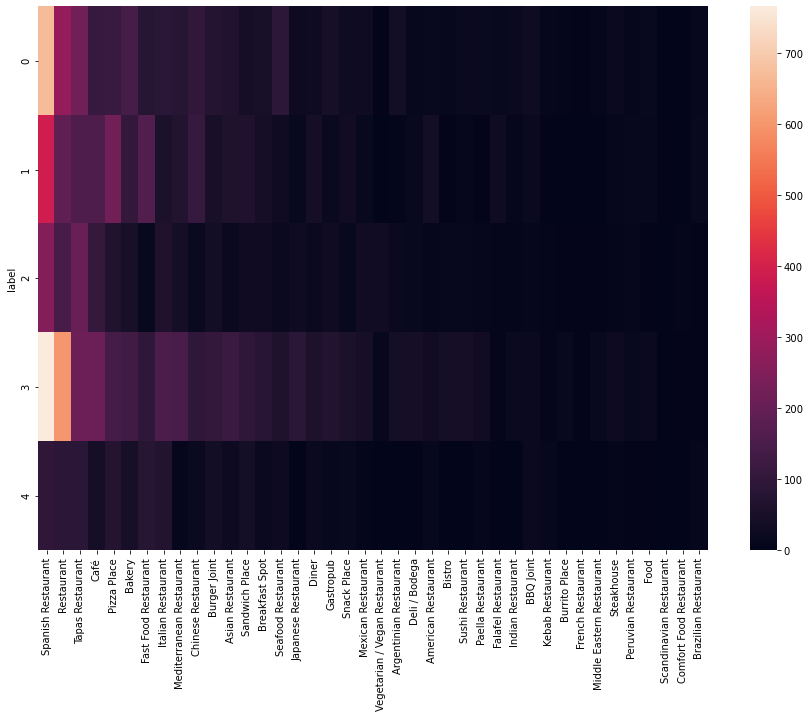

In [221]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(venues_40_bylabel)

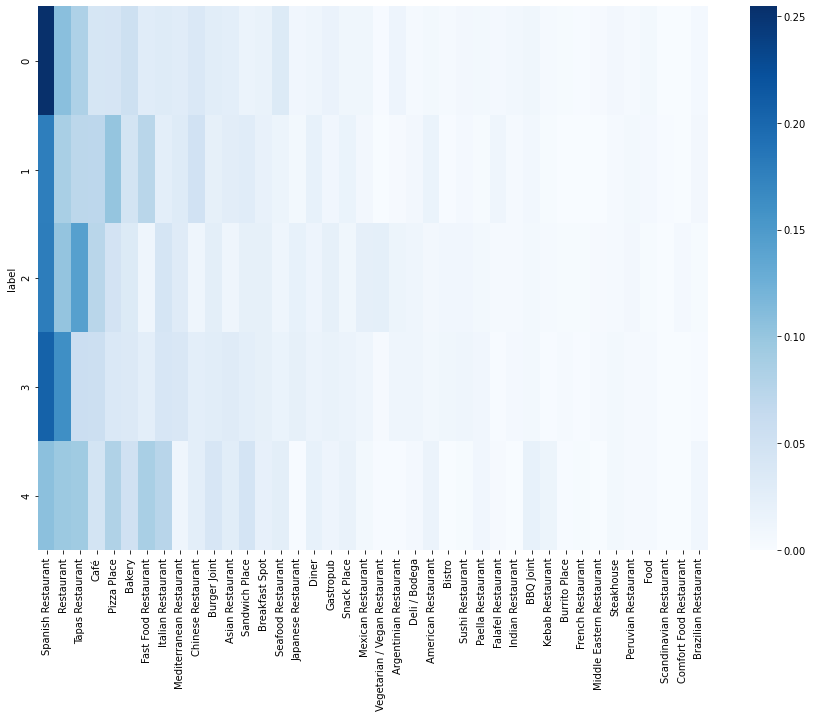

In [195]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(venues_40_bylabel_norm, cmap="Blues")

In [217]:
pd.concat([venues_categories_sum[venues_categories_sum['label'] == 0].drop('label', axis=1).sum(axis=1).describe().to_frame(),
           venues_categories_sum[venues_categories_sum['label'] == 1].drop('label', axis=1).sum(axis=1).describe().to_frame(),
           venues_categories_sum[venues_categories_sum['label'] == 2].drop('label', axis=1).sum(axis=1).describe().to_frame(),
           venues_categories_sum[venues_categories_sum['label'] == 3].drop('label', axis=1).sum(axis=1).describe().to_frame(),
           venues_categories_sum[venues_categories_sum['label'] == 4].drop('label', axis=1).sum(axis=1).describe().to_frame(),], axis=1).set_axis(['0', '1', '2', '3', '4'], axis=1, inplace=False)

0          1           2           3           4
count   30.000000   30.00000   18.000000   42.000000   11.000000
mean    93.000000   76.50000   84.500000   92.833333   88.818182
std     15.507507   16.39754   22.476785   13.564510   14.176164
min     28.000000   42.00000   29.000000   45.000000   61.000000
25%     93.500000   66.25000   74.500000   90.500000   87.500000
50%    100.000000   79.00000  100.000000  100.000000   94.000000
75%    100.000000   87.50000  100.000000  100.000000  100.000000
max    100.000000  100.00000  100.000000  100.000000  100.000000

### 3.2. Clustering neighborhoods per venue price
We have the information about the price in a dataframe column. However, in order to apply any machine learning algorithms we need to have this information in their own column. We will use the ```get_dummies``` method in order to get a dataframe where the columns will be the price category, and the value will be a boolean-like integer.

In [142]:
# We have the information we downloaded from FourSquare in the venues_price dataframe
venues_price.head(3)

Neighborhood code     Neighborhood name  Price           Venue  \
0                101  PALACIO                   1  Pizzeria Mayor   
1                101  PALACIO                   1  Federal Café 2   
2                101  PALACIO                   1       Gyoza Go!   

   Venue Latitude  Venue Longitude       Venue Category  
0       40.412789        -3.717474          Pizza Place  
1       40.414460        -3.708774                 Café  
2       40.416179        -3.708612  Dumpling Restaurant

In [143]:
# Let's move the price information into columns
price_dummies = pd.get_dummies(venues_price['Price'])
price_dummies.rename(columns={1: 'Price 1', 2: 'Price 2', 3: 'Price 3', 4: 'Price 4'}, inplace=True)
price_dummies.head()

Price 1  Price 2  Price 3  Price 4
0        1        0        0        0
1        1        0        0        0
2        1        0        0        0
3        1        0        0        0
4        1        0        0        0

In [144]:
# Then, we concat the venues dataframe with the prices dataframe
venues_price_cat = pd.concat([venues_price, price_dummies], axis=1)
venues_price_cat.head()

Neighborhood code     Neighborhood name  Price                 Venue  \
0                101  PALACIO                   1        Pizzeria Mayor   
1                101  PALACIO                   1        Federal Café 2   
2                101  PALACIO                   1             Gyoza Go!   
3                101  PALACIO                   1          Pez Tortilla   
4                101  PALACIO                   1  La Taquería de Birra   

   Venue Latitude  Venue Longitude       Venue Category  Price 1  Price 2  \
0       40.412789        -3.717474          Pizza Place        1        0   
1       40.414460        -3.708774                 Café        1        0   
2       40.416179        -3.708612  Dumpling Restaurant        1        0   
3       40.411782        -3.710517     Tapas Restaurant        1        0   
4       40.411605        -3.713569   Mexican Restaurant        1        0   

   Price 3  Price 4  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0

In [145]:
# We then group the price categories per neighborhood
prices_df = venues_price_cat.groupby(['Neighborhood code', 'Neighborhood name']).sum()[['Price 1', 'Price 2', 'Price 3', 'Price 4']]
prices_df

Price 1  Price 2  Price 3  Price 4
Neighborhood code Neighborhood name                                       
101               PALACIO                    20       45       32        0
102               EMBAJADORES                20       47        8        0
103               CORTES                     29       87       21        0
104               JUSTICIA                   31      100       15        2
105               UNIVERSIDAD                34       74       20        0
...                                         ...      ...      ...      ...
2101              ALAMEDA DE OSUNA           43       55        8        2
2102              AEROPUERTO                 38       36        6        1
2103              CASCO H.BARAJAS            45       45        8        2
2104              TIMON                      28       41        7        0
2105              CORRALEJOS                 19       16        6        0

[131 rows x 4 columns]

In [146]:
# In order to get an idea of the number of venues per price category, we sum the columns
prices_df.sum(axis=0)

Price 1    4529
Price 2    6440
Price 3    1520
Price 4      82
dtype: int64

The most common type of restaurant is the restaurant tagged with 'Price 2'. There are not many *expensive* restaurants in Madrid.

In [147]:
# We add this information to our neighborhoods dataframe, in order to get geographical information
nb_prices = nb_final.merge(prices_df, left_on='code', right_on='Neighborhood code')
nb_prices.head()

neighborhood code  district code                  name  area (m2)  \
0                  1              1  PALACIO                 1471085   
1                  1              2  IMPERIAL                 967500   
2                  1              3  PACIFICO                 750065   
3                  1              4  RECOLETOS                870857   
4                  1              5  EL VISO                 1708046   

   perimeter (m)  code codbarrio   latitude  longitude  Price 1  Price 2  \
0           5754   101       1-1  40.416841  -3.711605       20       45   
1           4557   201       2-1  40.406598  -3.719600       39       65   
2           4005   301       3-1  40.404606  -3.678362       24       51   
3           3927   401       4-1  40.424700  -3.685462       30       92   
4           5269   501       5-1  40.449060  -3.686285       50       71   

   Price 3  Price 4  
0       32        0  
1       24        1  
2        6        0  
3       19        2  
4       17        1

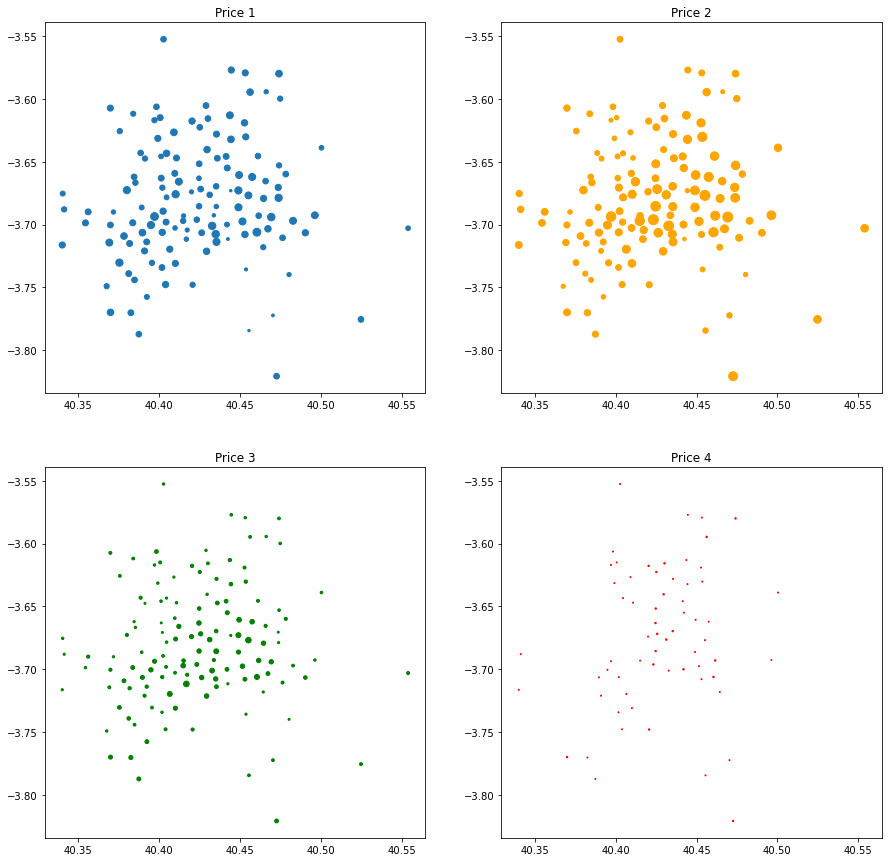

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].scatter(nb_prices['latitude'], nb_prices['longitude'], s=nb_prices['Price 1'])
axs[0, 0].set_title('Price 1')

axs[0, 1].scatter(nb_prices['latitude'], nb_prices['longitude'], s=nb_prices['Price 2'], c='orange')
axs[0, 1].set_title('Price 2')

axs[1, 0].scatter(nb_prices['latitude'], nb_prices['longitude'], s=nb_prices['Price 3'], c='green')
axs[1, 0].set_title('Price 3')

axs[1, 1].scatter(nb_prices['latitude'], nb_prices['longitude'], s=nb_prices['Price 4'], c='red')
axs[1, 1].set_title('Price 4');


In [151]:
# We will cluster the neighborhoods per price category, so let's extract that information
prices = nb_prices[['Price 1', 'Price 2', 'Price 3', 'Price 4']]
prices.head()

Price 1  Price 2  Price 3  Price 4
0       20       45       32        0
1       39       65       24        1
2       24       51        6        0
3       30       92       19        2
4       50       71       17        1

In [152]:
# We use standard scaler to get ready the document for processing
scaler = StandardScaler()
prices_std = scaler.fit_transform(prices)

In [153]:
kmeans_prices = KMeans(n_clusters=4, random_state=0).fit(prices_std)
kmeans_prices.labels_[0:10]

array([3, 3, 2, 0, 3, 1, 3, 1, 0, 1], dtype=int32)

In [155]:
# Let's add the label to our neighborhoods dataframe
nb_prices['label'] = kmeans_prices.labels_ 

In [156]:
nb_prices[nb_prices['label'] == 0][['Price 1', 'Price 2', 'Price 3', 'Price 4']].describe()

Price 1     Price 2    Price 3    Price 4
count  30.000000   30.000000  30.000000  30.000000
mean   35.433333   58.866667  13.666667   1.600000
std     7.514048   17.631737   4.293807   0.498273
min    17.000000   37.000000   6.000000   1.000000
25%    31.250000   45.250000  10.250000   1.000000
50%    34.000000   54.500000  14.500000   2.000000
75%    41.750000   69.500000  16.750000   2.000000
max    48.000000  100.000000  21.000000   2.000000

In [157]:
nb_prices[nb_prices['label'] == 1][['Price 1', 'Price 2', 'Price 3', 'Price 4']].describe()

Price 1    Price 2    Price 3    Price 4
count  48.000000  48.000000  48.000000  48.000000
mean   37.583333  41.375000   8.812500   0.333333
std     5.877593  13.789643   3.098773   0.476393
min    28.000000  20.000000   4.000000   0.000000
25%    33.750000  33.000000   6.000000   0.000000
50%    36.000000  39.000000   9.000000   0.000000
75%    40.000000  48.000000  10.000000   1.000000
max    53.000000  77.000000  15.000000   1.000000

In [158]:
nb_prices[nb_prices['label'] == 2][['Price 1', 'Price 2', 'Price 3', 'Price 4']].describe()

Price 1   Price 2    Price 3    Price 4
count  30.000000  30.00000  30.000000  30.000000
mean   20.100000  32.80000   6.866667   0.233333
std     8.014427  14.19179   2.750966   0.430183
min     2.000000   6.00000   1.000000   0.000000
25%    17.250000  20.25000   5.000000   0.000000
50%    22.000000  33.00000   6.500000   0.000000
75%    27.000000  44.25000   8.000000   0.000000
max    28.000000  59.00000  15.000000   1.000000

In [159]:
nb_prices[nb_prices['label'] == 3][['Price 1', 'Price 2', 'Price 3', 'Price 4']].describe()

Price 1     Price 2    Price 3    Price 4
count  23.000000   23.000000  23.000000  23.000000
mean   46.043478   74.086957  20.913043   0.478261
std    11.419593   13.747440   4.501647   0.593109
min    20.000000   45.000000  14.000000   0.000000
25%    41.000000   65.500000  18.500000   0.000000
50%    50.000000   71.000000  20.000000   0.000000
75%    53.000000   84.500000  23.500000   1.000000
max    62.000000  100.000000  32.000000   2.000000

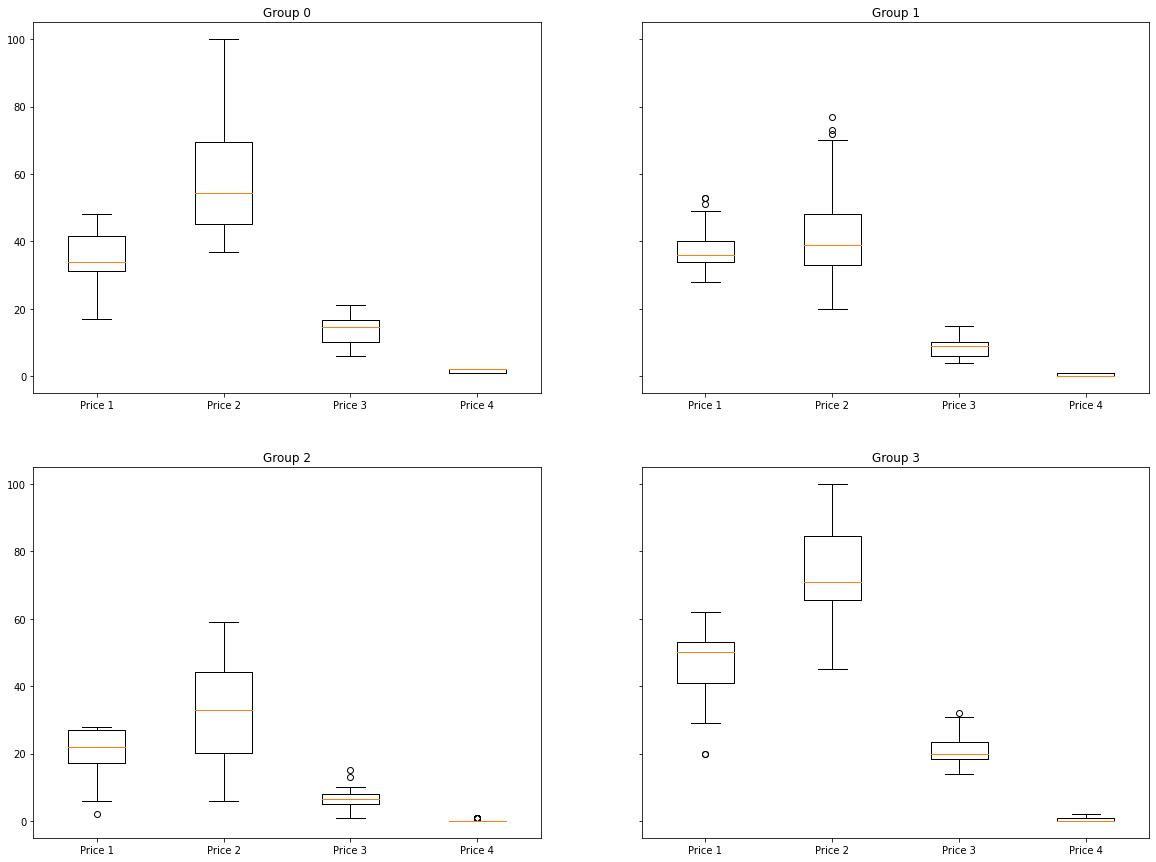

In [160]:
prices = ['Price 1', 'Price 2', 'Price 3', 'Price 4']

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(20, 15))
axes[0, 0].set_title('Group 0')
axes[0, 0].boxplot(nb_prices[nb_prices["label"] == 0][prices], labels=prices)
axes[0, 1].set_title('Group 1')
axes[0, 1].boxplot(nb_prices[nb_prices["label"] == 1][prices], labels=prices)
axes[1, 0].set_title('Group 2')
axes[1, 0].boxplot(nb_prices[nb_prices["label"] == 2][prices], labels=prices)
axes[1, 1].set_title('Group 3')
axes[1, 1].boxplot(nb_prices[nb_prices["label"] == 3][prices], labels=prices);

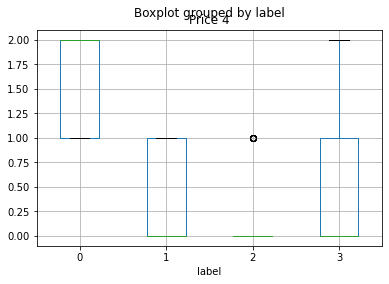

In [161]:
nb_prices.boxplot('Price 4', by="label");

In [164]:
nb_prices['codbarrio'] = replaceZeroWithHyphen(nb_prices['code'].astype(str))

In [165]:
# We will finally show the map
bins = [0, 1, 2, 3, 4]


m = folium.Map(location=mad_ll, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_geojson,
    data=nb_prices,
    columns=["codbarrio", "label"],
    key_on="feature.properties.codbarrio",
    fill_color="RdYlBu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Neighborhood category",
    bins=bins,
    reset=True
).add_to(m)

for name, label, lat, lng in list(zip(nb_prices['name'], nb_prices["label"], nb_prices['latitude'], nb_prices['longitude'])):
    folium.Circle(
        radius=100,
        location=[lat,lng],
        popup=name + "- " + str(label),
        color="black",
        fill=True,
        fill_color="black"
    ).add_to(m)

m

## 4. Results

Let's suppose I want to open a mexican restaurant not very cheap but not very expensive, let's say category 2 in the Foursquare price category ranking. Looking at the heatmap, we see that the cluster with a higher relative amount of mexican restaurants is cluster 2.